## Import Necessary Modules

In [ ]:
# Importing Librararies

!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26782 sha256=7d43484bdb7c1854cf788243b2841de4d9bd2eed4f4d7e83b4d755d0af7f26bd
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandasql
from scipy.stats import pearsonr
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# FORECASTING

In [ ]:
acc_1 = pd.read_excel('/content/drive/MyDrive/Mining Project/Additional Accidents for TimeSeries/Accidents with Degree Inj1-6 2000 -2005 - from MSTR text to Excel.xlsx')
acc_2 = pd.read_excel('/content/drive/MyDrive/Mining Project/Additional Accidents for TimeSeries/Accidents with Degree Inj1-6 2006 -2010 - from MSTR text to Excel.xlsx')
acc_3 = pd.read_excel('/content/drive/MyDrive/Mining Project/Additional Accidents for TimeSeries/Accidents with Degree Inj1-6 2011 -2020 - from MSTR text to Excel.xlsx')


In [ ]:
acc_1.head()

,Document No.,Accident Classification,Accident Date (Accidents),Accident Time (Accidents),Accident Type Code,Activity Code (Accidents),Age (Accidents),Body Part Code,Calendar Quarter,Calendar Year,Calendar Year Qtr,Contractor ID,Controller ID @ Accidents,Controller Name @ Accidents,Date of Birth (Accidents),Degree of Injury Code,Degree of Injury Name,Equip. Manufacturer Code,Equip. Model No.,FIPS State Code,Immediate Reporting Code,Injury Source Code,Investigation Begin Date,Job Experience,Mine Experience,Mine ID,Narrative,Nature of Injury,Number of Injuries,Occupation (Accidents),Occupation Type,Operator ID @ Accidents,Operator Name @ Accidents,Return to Work Date,Shift Beginning Time,Subunit Code,Subunit Name,Transferred or Terminated,Type of Equipment,UG Location Code,UG Mining Method Code,# All Injuries,Days Lost,Days Restricted Duty,Schedule Charge (Days),Total Experience
0,220000040030,HANDLING OF MATERIALS,2000-01-03,715,Over-exertion NEC,Inspect equipment or mine,35.0,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),1,2000,20001,NaN,M00293,Charles H Bracken Jr,5/4/1964,3,DAYS AWAY FROM WORK ONLY,NO VALUE FOUND,?,NEW YORK,NOT MARKED,"CHAIN,ROPE,CABLE-NT CONVY",NaT,4.59,4.59,3001520,EE WAS RAISING A SCREEN COVER USING A PULL CAB...,"SPRAIN,STRAIN RUPT DISC",1,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",Surface,L15017,Barton Mines Co LLC,2000-03-21,700.0,30,MILL OPERATION/PREPARATION PLANT,N,NO VALUE FOUND,NO VALUE FOUND,NO VALUE FOUND,1,55.0,NaN,NaN,4.59
1,220000060001,SLIP OR FALL OF PERSON,2000-01-02,1230,Fall onto or against objects,Electrical maintenance,48.0,THIGH/FEMUR,1,2000,20001,NaN,C02508,Massey Energy Company,6/18/1951,6,"NO DYS AWY FRM WRK,NO RSTR ACT",NO VALUE FOUND,?,WEST VIRGINIA,NOT MARKED,METAL COVERS & GUARDS,NaT,17.00,17.00,4606188,INJURED WAS INSTALLING A LIGHT BULB IN LOADOUT...,"CUT,LACER,PUNCT-OPN WOUND",1,"Electrician, Lineman",Surface,P11051,"Elk Run Coal Company, LLC",2000-01-02,700.0,30,MILL OPERATION/PREPARATION PLANT,N,NO VALUE FOUND,NO VALUE FOUND,NO VALUE FOUND,1,NaN,NaN,NaN,18.00
2,220000060002,HANDTOOLS (NONPOWERED),2000-01-03,1330,Struck by... NEC,Hand tools (not powered),33.0,FINGER(S)/THUMB,1,2000,20001,NaN,M10838,Potash Corp Of Saskatchewan,12/15/1966,6,"NO DYS AWY FRM WRK,NO RSTR ACT",Not Reported,?,NORTH CAROLINA,NOT MARKED,KNIFE,NaT,0.44,0.44,3100212,"CUTTING WITH A BELT KNIFE, CUT THROUGH GLOVE I...","CUT,LACER,PUNCT-OPN WOUND",1,"Miner, NEC",UG (Non-Face),L14180,PCS Phosphate Company Inc,2000-01-04,800.0,3,"STRIP, QUARY, OPEN PIT",N,Hand tools (not powered),NO VALUE FOUND,NO VALUE FOUND,1,NaN,NaN,NaN,0.44
3,220000070002,HANDLING OF MATERIALS,2000-01-01,230,"Absorption of radiations, caustics, toxic and ...",Handling supplies or material,48.0,EYE(S) OPTIC NERVE/VISON,1,2000,20001,NaN,M01961,Mittal-US Steel Canada-Cliffs Natural Resources,1/15/1951,6,"NO DYS AWY FRM WRK,NO RSTR ACT",Not listed,830E,MINNESOTA,NOT MARKED,"COAL & PETROL PRODUCT,NEC",2000-01-01,5.30,5.30,2101600,DRIVER WAS IN THE SERVICE CENTER. SHE HAD COMP...,"BURN,CHEMICL-FUME,COMPOUN",1,Truck driver,UG (Non-Face),L02202,Hibbing Taconite Company,2000-01-02,2300.0,30,MILL OPERATION/PREPARATION PLANT,N,Ore haulage trucks - off highway trucks,NO VALUE FOUND,NO VALUE FOUND,1,NaN,NaN,NaN,5.30
4,220000070003,HANDLING OF MATERIALS,2000-01-03,800,Over-exertion in lifting objects,Handling supplies or material,38.0,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),1,2000,20001,NaN,C15833,Peabody Energy,5/11/1961,3,DAYS AWAY FROM WORK ONLY,NO VALUE FOUND,?,KENTUCKY,NOT MARKED,"METAL,NEC(PIPE,WIRE,NAIL)",2000-01-03,0.09,0.09,1517587,EMPLOYEE'S WAS LOADING HIS PLATES ON TO THE BO...,"SPRAIN,STRAIN RUPT DISC",1,"Roof bolter, Rock bolter, Pinner, Mobile roof...",UG (Face),P23175,Ohio County Coal Company,2000-01-07,700.0,1,UNDERGROUND,N,NO VALUE FOUND,FACE,Continuous Mining,1,3.0,NaN,NaN,20.00


In [ ]:
# join all the accident data into one dataset
accs = [acc_1,acc_2, acc_3]
accident_ext = pd.concat(accs)

In [ ]:
# number of accidents per operator
operator = accident_ext.groupby('Operator ID @ Accidents').agg({'Mine ID':'count'})
operator.sort_values(by='Mine ID', ascending = False).head(10)

,Mine ID
Operator ID @ Accidents,
P00812,2019
L12058,1927
P01155,1898
L16168,1868
L15317,1829
P23981,1664
L14843,1451
L17191,1398
P17353,1190


1st and 3rd operator have stopped working. They also have high number of accidents. It could have been the case that they were forced to shut down

### ARIMA

### L16168

In [ ]:
# yearly accidents for given operator
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L16168'] # change mine id here
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Q').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
new

,Accidents
Accident Date (Accidents),
2000-03-01,39
2000-06-01,33
2000-09-01,50
2000-12-01,41
2001-03-01,32
...,...
2019-12-01,14
2020-03-01,12
2020-06-01,12


Checking for stationarity of the data. Plot the data and see if over time is it trending up or down. If its not trending either direction and is just sideways then it is said to be stationary

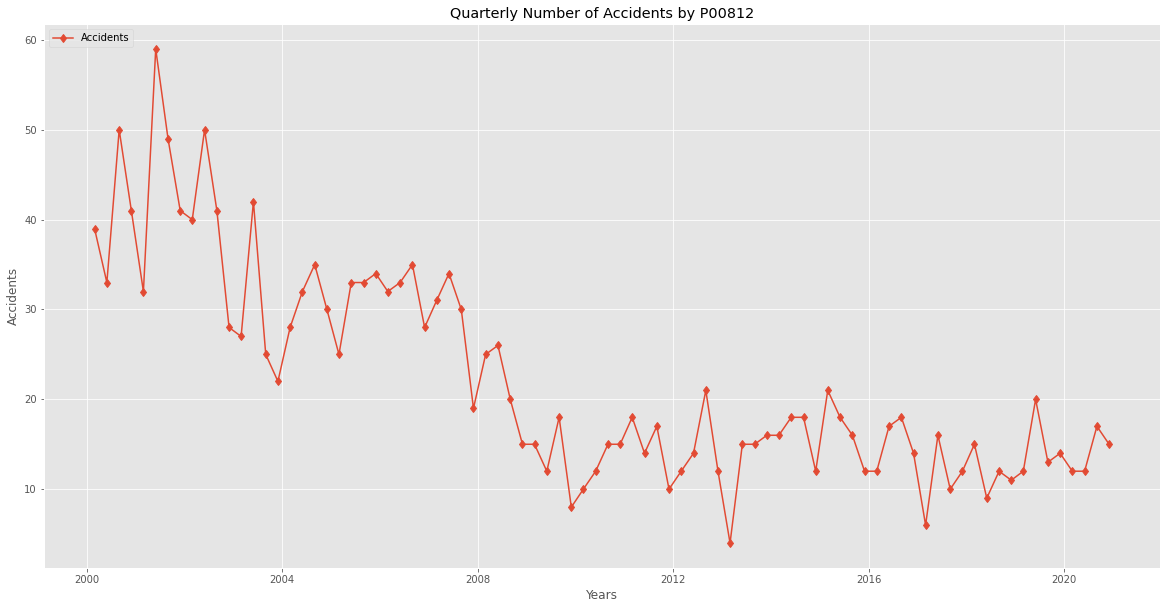

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new.index, new.Accidents, marker='d', label='Accidents')
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('Quarterly Number of Accidents by P00812')
plt.legend(loc=2)
plt.show()

result = adfuller(new['Accidents'])





The data seems to be trending downwards, meaning it is not stationary

In [ ]:
print('Test statistic:'+str(result[0]))
print('p value:'+str(result[1]))

Test statistic:-1.6117658562347006
p value:0.4770486965826336


Statistical way of checking stationary-ness

Data is not stationary. We want test statistic to be as negative as possible and p value be < 0.05

This data needs to be transformed first. We will do differencing

<Figure size 1440x720 with 0 Axes>

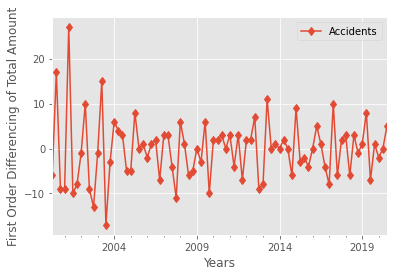

Test statistic:-4.225975350058667
p value:0.0005952746337758173


In [ ]:
new_diff = new.diff(1).dropna(inplace=False)
plt.figure(figsize=(20,10))
new_diff.iloc[:-1].plot(marker='d')
plt.xlabel('Years')
plt.ylabel('First Order Differencing of Total Amount')

plt.show()

result = adfuller(new_diff['Accidents'])

print('Test statistic:'+ str(result[0]))

print('p value:'+str(result[1]))

No observable trend in data, the data looks stationary after taking the first order differencing

Now it is stationary. Value of d=1

Finding value of p(auto regressive lags) and q(number of moving average term)

Choose the value of (p,q) corresponding to the AIC and BIC score

In [ ]:
for p in range(4):
    for q in range(3):
      try:
        model = SARIMAX(new, order=(p,1,q), trend='c') # SARIMAX(p,d,q) d=1 here since data was stationary and we need to difference it once
        results = model.fit()
        
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

0 0 559.1498707968099 563.9875520124031
0 1 533.3982949313646 540.6548167547544


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


0 2 534.8158118693982 544.4911743005846
1 0 550.8991663741195 558.1556881975093
1 1 535.266313696285 544.9416761274714


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


1 2 533.5836449436573 545.6778479826403
2 0 527.370933496712 537.0462959278984
2 1 526.0045036101292 538.0987066491122


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


2 2 522.1031611980909 536.6162048448705
3 0 524.6651013469132 536.7593043858961


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


3 1 526.644453951692 541.1574975984715


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


3 2 523.2492866925968 540.181170947173


522 and 536 are the lowest scores. so p =2 and q=2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


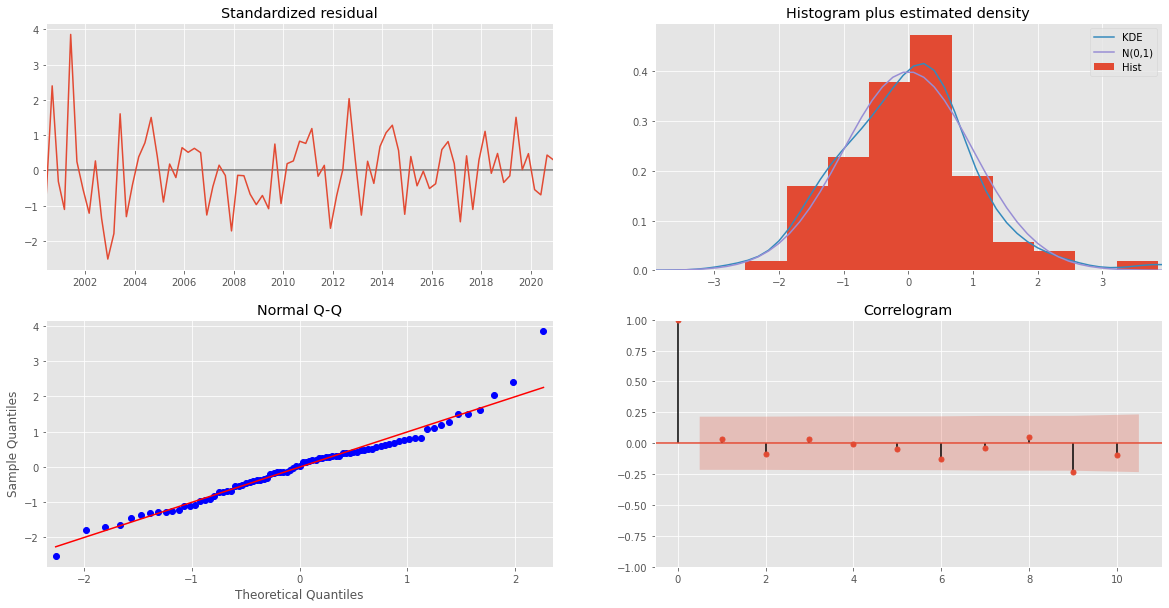

                           Statespace Model Results                           
Dep. Variable:              Accidents   No. Observations:                   84
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -255.052
Date:                Mon, 09 Aug 2021   AIC                            522.103
Time:                        14:36:18   BIC                            536.616
Sample:                    03-01-2000   HQIC                           527.934
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2995      0.372     -0.806      0.421      -1.028       0.429
ar.L1          0.4513      0.168      2.684      0.007       0.122       0.781
ar.L2         -0.5028      0.125     -4.010      0.0

In [ ]:
model = SARIMAX(new, order=(2,1,2), trend='c')
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

The model diagnostics plots tell us that the model is a fairly good one as the model 

● Does not have any obvious structures in the residuals in the Standardized residual plot.

● The KDE and N(0,1) lines in the Histogram plus estimated density are almost the same. 

● Have dots lying along the red line in the Q-Q plot.

● 95% of the correlations for lag greater than 0 should is not significant in the Correlogram

Predicting the last 10 quarters of the data using the previous months to get a sense of the model's predicting abiloty

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

# getting the values for the confidence interval, this will be shaded in the plot to get an idea of the model confidence
lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

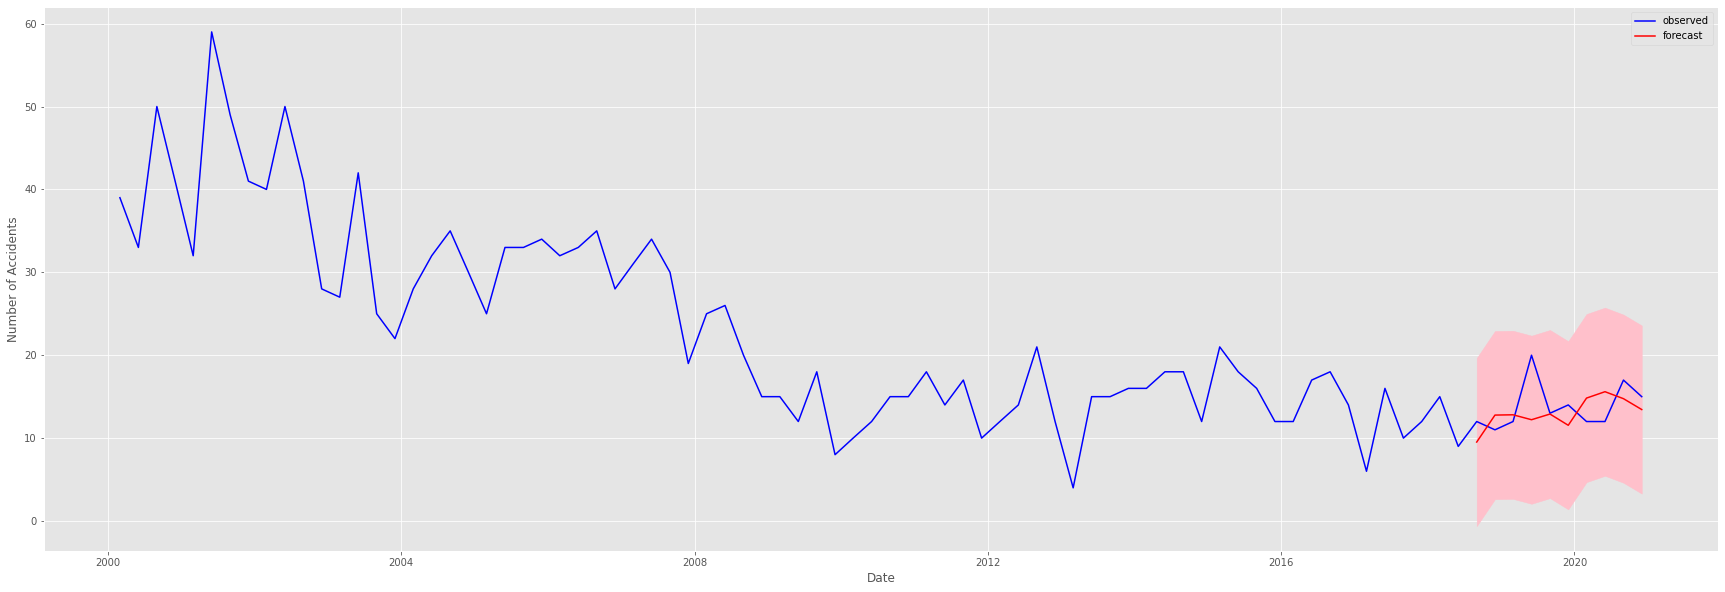

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

The blue line is the total number of actual accidents. The red line is a prediction by the model on the last 10 quarters based on data from the previous quarters. The pink shaded area is the lower and upper bound of the model prediction or the confidence interval of predictions by the model. This gives an idea of the accuracy of the model.

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
10.492639121746208


Predicitng the next 5 quarters into the future

In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


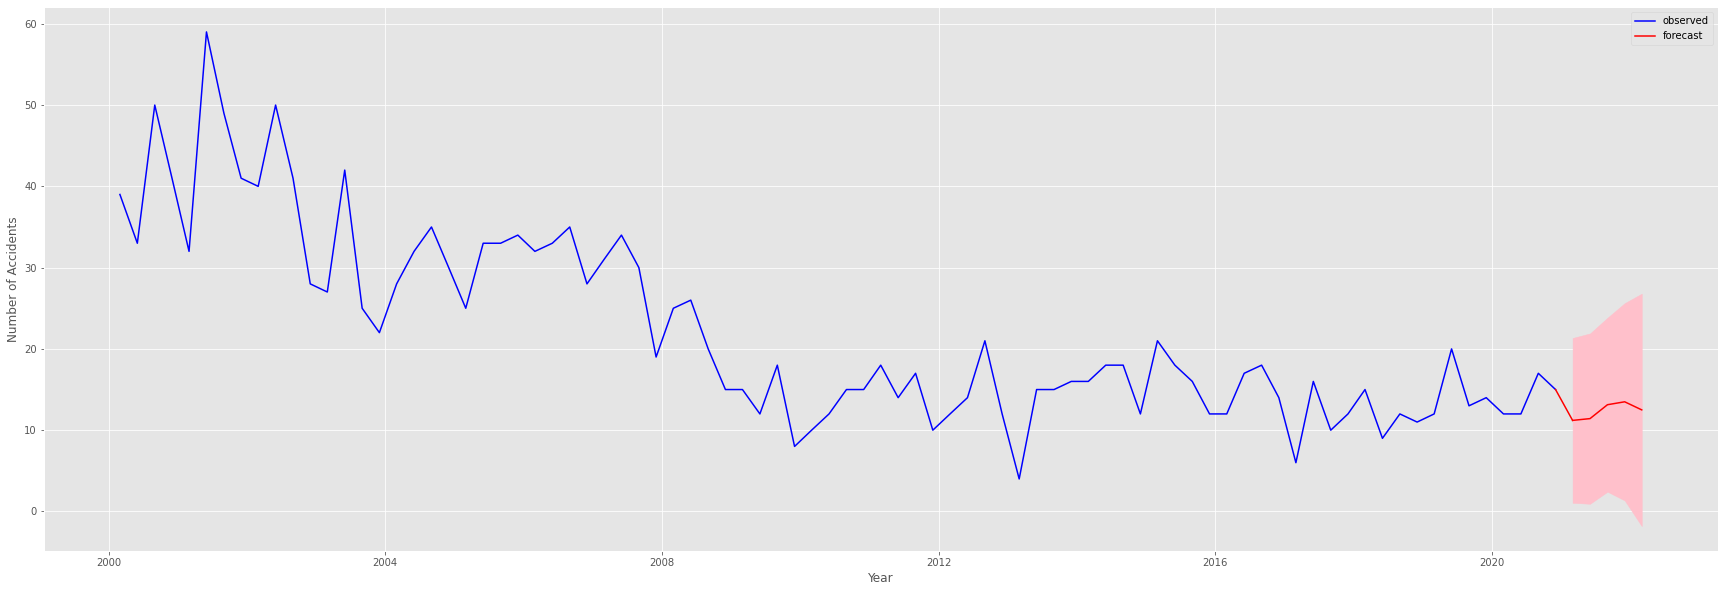

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


The red line is a prediction of the next 5 quarters for this particular operator given by our model.

In [ ]:
forcast= results.forecast(5)
forcast

2021-03-01    11.204729
2021-06-01    11.424933
2021-09-01    13.132901
2021-12-01    13.493491
2022-03-01    12.498027
Freq: QS-DEC, dtype: float64

### L12058

In [ ]:
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L12058']
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Y').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
new

,Accidents
Accident Date (Accidents),
2000-12-01,102
2001-12-01,44
2002-12-01,54
2003-12-01,64
2004-12-01,56
2005-12-01,72
2006-12-01,151
2007-12-01,198
2008-12-01,211


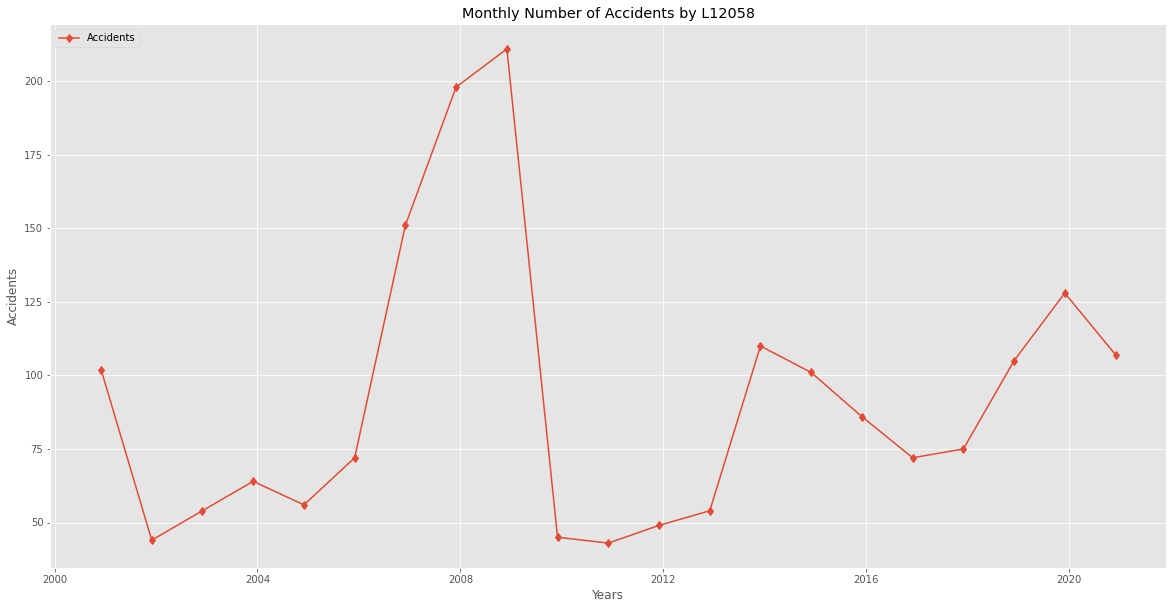

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new.index, new.Accidents, marker='d', label='Accidents')
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('Monthly Number of Accidents by L12058')
plt.legend(loc=2)
plt.show()

result = adfuller(new['Accidents'])

There seems to be no trend in the data. The data looks stationary

In [ ]:
print('Test statistic:'+str(result[0]))
print('p value:'+str(result[1]))

Test statistic:-6.7580880077766246
p value:2.837831175179227e-09


In [ ]:
# new_diff = new.diff(1).dropna(inplace=False)
# plt.figure(figsize=(20,10))
# new_diff.iloc[:-1].plot(marker='d')
# plt.xlabel('Years')
# plt.ylabel('First Order Differencing of Total Amount')

# plt.show()

# result = adfuller(new_diff['Accidents'])

# print('Test statistic:'+ str(result[0]))

# print('p value:'+str(result[1]))

Now the data is stationary after differencing it once. So value of d = 1

In [ ]:
for p in range(4):
    for q in range(3):
      try:
        model = SARIMAX(new, order=(p,0,q), trend='c')
        results = model.fit()
        
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

0 0 225.09179497817973 227.1808398536266
0 1 219.61925973711283 222.7528270502831
0 2 220.8483653348736 225.02645508576728


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)


1 0 221.28687741225525 224.4204447254255
1 1 221.18502710685843 225.36311685775212


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)


1 2 222.8483160447375 228.0709282333546
2 0 218.88700264387143 223.06509239476512


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization faile

2 1 215.28173897067157 220.5043511592887


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)


2 2 217.3468182080534 223.61395283439396
3 0 219.34923313632262 224.57184532493974


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)


3 1 217.4249712123663 223.69210583870685
3 2 222.60234835226828 229.91400541633223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 2, q=1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


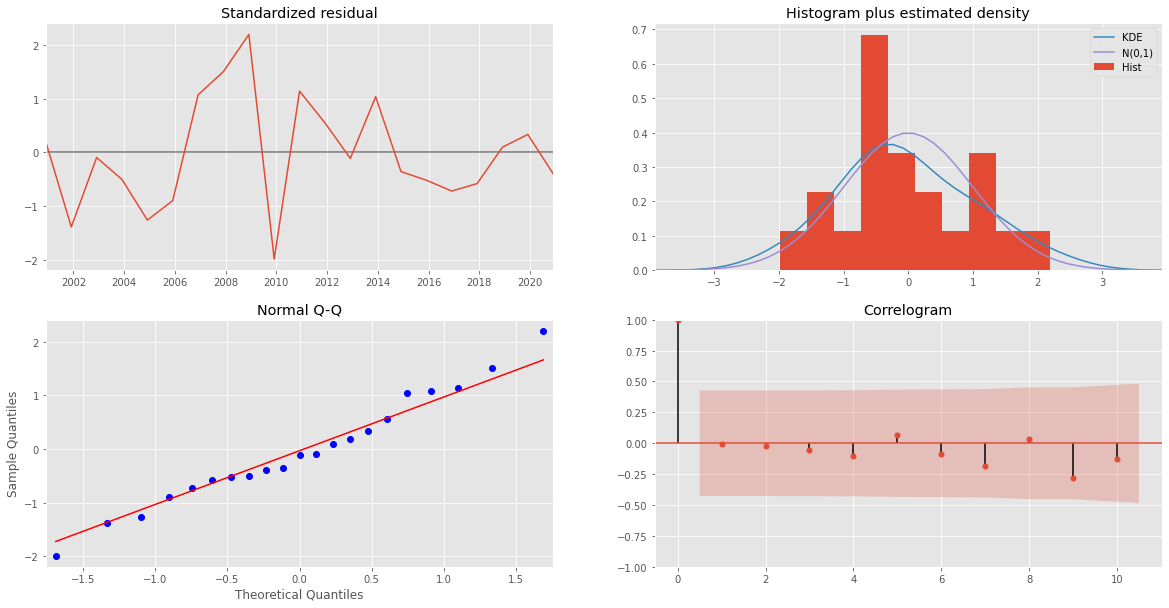

                           Statespace Model Results                           
Dep. Variable:              Accidents   No. Observations:                   21
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -102.641
Date:                Mon, 09 Aug 2021   AIC                            215.282
Time:                        14:36:22   BIC                            220.504
Sample:                    12-01-2000   HQIC                           216.415
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.6391     13.107      3.177      0.001      15.951      67.327
ar.L1          1.2459      0.128      9.757      0.000       0.996       1.496
ar.L2         -0.6901      0.141     -4.897      0.0

In [ ]:
model = SARIMAX(new, order=(2,0,1), trend='c')
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

The model diagnostics plots tell us that the model is a fairly good one as the model 

● Does not have any obvious structures in the residuals in the Standardized residual plot.

● The KDE and N(0,1) lines in the Histogram plus estimated density are almost the same. 

● Have dots lying along the red line in the Q-Q plot.

● 95% of the correlations for lag greater than 0 should is not significant in the Correlogram

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

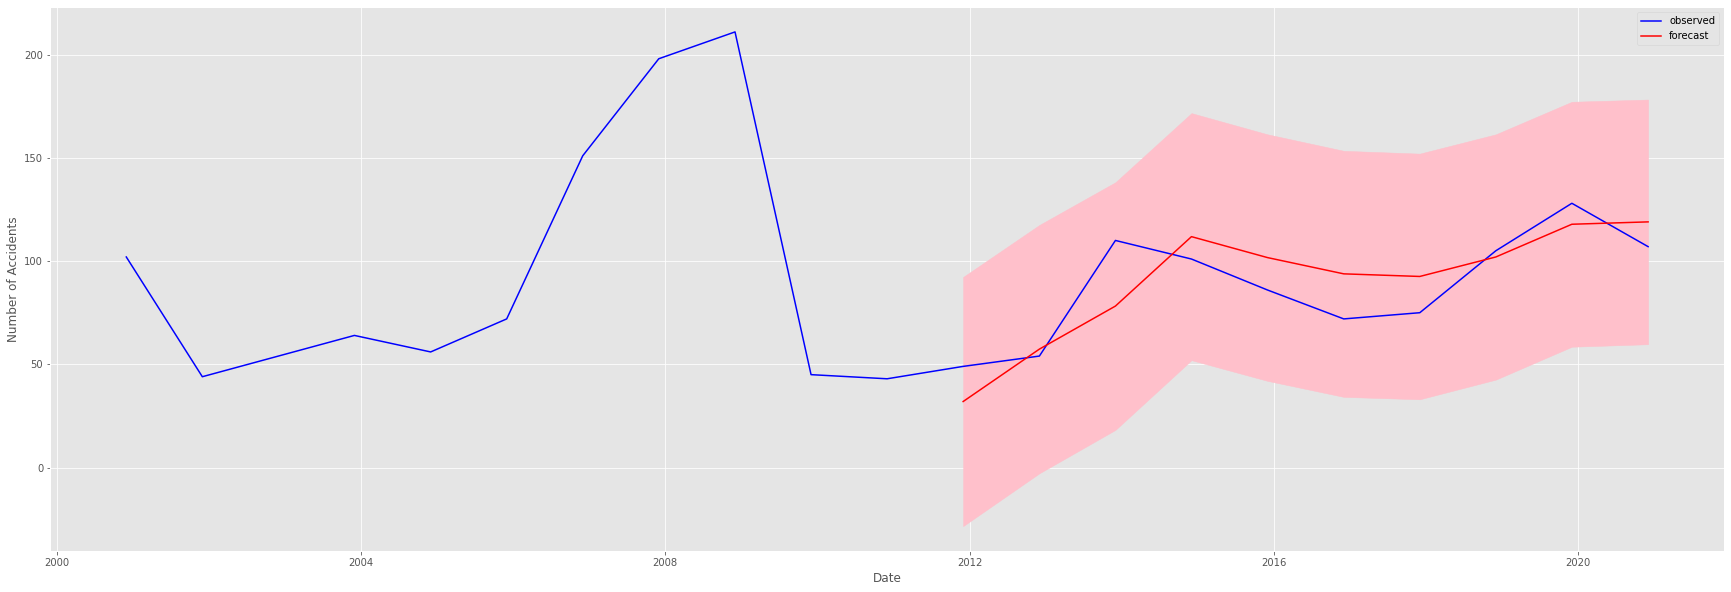

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

The blue line is the total number of actual accidents. The red line is a prediction by the model on the last 10 quarters based on data from the previous quarters. The pink shaded area is the lower and upper bound of the model prediction or the confidence interval of predictions by the model. This gives an idea of the accuracy of the model.

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
271.56622448050706


In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


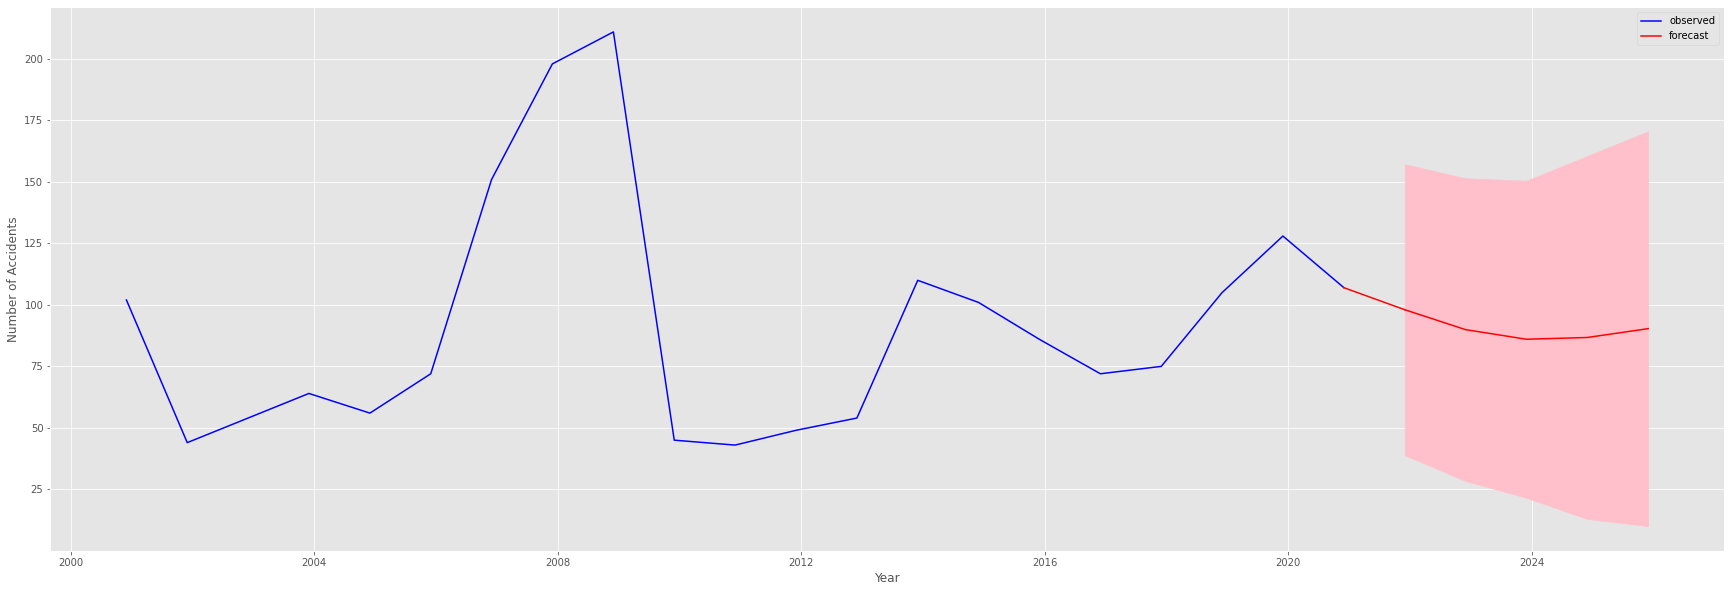

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


The red line is a prediction of the next 5 quarters for this particular operator given by our model.

In [ ]:
forcast= results.forecast(2)
forcast

2021-12-01    98.043399
2022-12-01    89.945527
Freq: AS-DEC, dtype: float64

### L14843

In [ ]:
# yearly accidents for given operator
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L14843'] # change mine id here
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Q').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
new

,Accidents
Accident Date (Accidents),
2000-03-01,35
2000-06-01,40
2000-09-01,51
2000-12-01,48
2001-03-01,31
...,...
2019-12-01,14
2020-03-01,12
2020-06-01,15


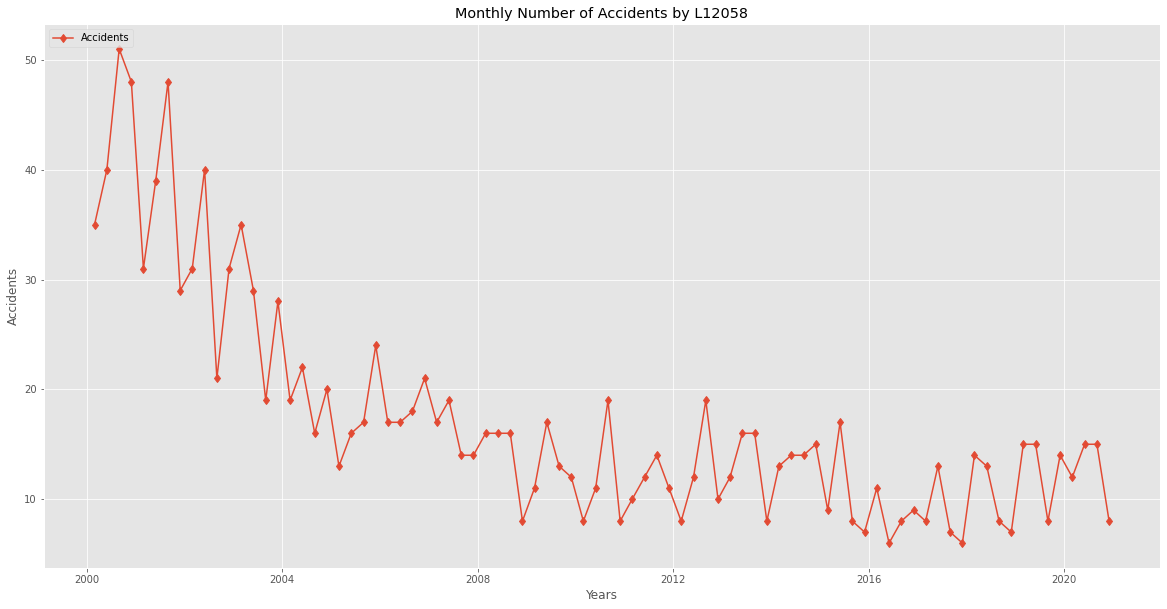

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new.index, new.Accidents, marker='d', label='Accidents')
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('Monthly Number of Accidents by L12058')
plt.legend(loc=2)
plt.show()

result = adfuller(new['Accidents'])

Data seems to be trending down visually. We should confirm it mathematically

In [ ]:
print('Test statistic:'+str(result[0]))
print('p value:'+str(result[1]))

Test statistic:-4.920310048222409
p value:3.183499946325214e-05


The data is stationary

In [ ]:
for p in range(4):
    for q in range(3):
      try:
        model = SARIMAX(new, order=(p,0,q), trend='c')
        results = model.fit()
        
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

0 0 630.1379150208779 634.9995486185645
0 1 585.3937245608254 592.6861749573553


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  

0 2 575.909243539165 585.6325107345383
1 0 546.9936613657256 554.2861117622556
1 1 523.4667015168941 533.1899687122674


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


1 2 589.4358156057242 601.5898995999407
2 0 540.0707313535889 549.7939985489622
2 1 524.9018179617304 537.055901955947


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


2 2 None None
3 0 512.6466963291141 524.8007803233306


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


3 1 510.46580200536755 525.0507027984274


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


3 2 496.85280626957956 513.8685238614828


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


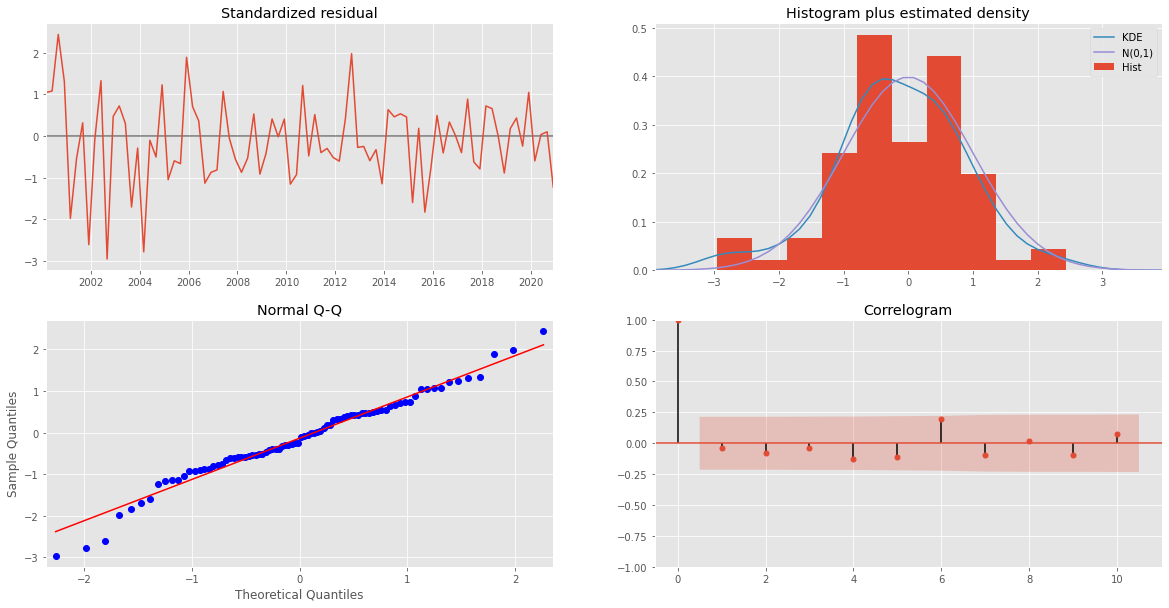

                           Statespace Model Results                           
Dep. Variable:              Accidents   No. Observations:                   84
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -241.426
Date:                Mon, 09 Aug 2021   AIC                            496.853
Time:                        14:36:26   BIC                            513.869
Sample:                    03-01-2000   HQIC                           503.693
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6856      0.894      0.767      0.443      -1.067       2.439
ar.L1          1.1826      0.098     12.119      0.000       0.991       1.374
ar.L2         -0.8476      0.155     -5.462      0.0

In [ ]:
model = SARIMAX(new, order=(3,0,2), trend='c')
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

The model diagnostics plots tell us that the model is a fairly good one as the model 

● Does not have any obvious structures in the residuals in the Standardized residual plot.

● The KDE and N(0,1) lines in the Histogram plus estimated density are almost the same. 

● Have dots lying along the red line in the Q-Q plot.

● 95% of the correlations for lag greater than 0 should is not significant in the Correlogram

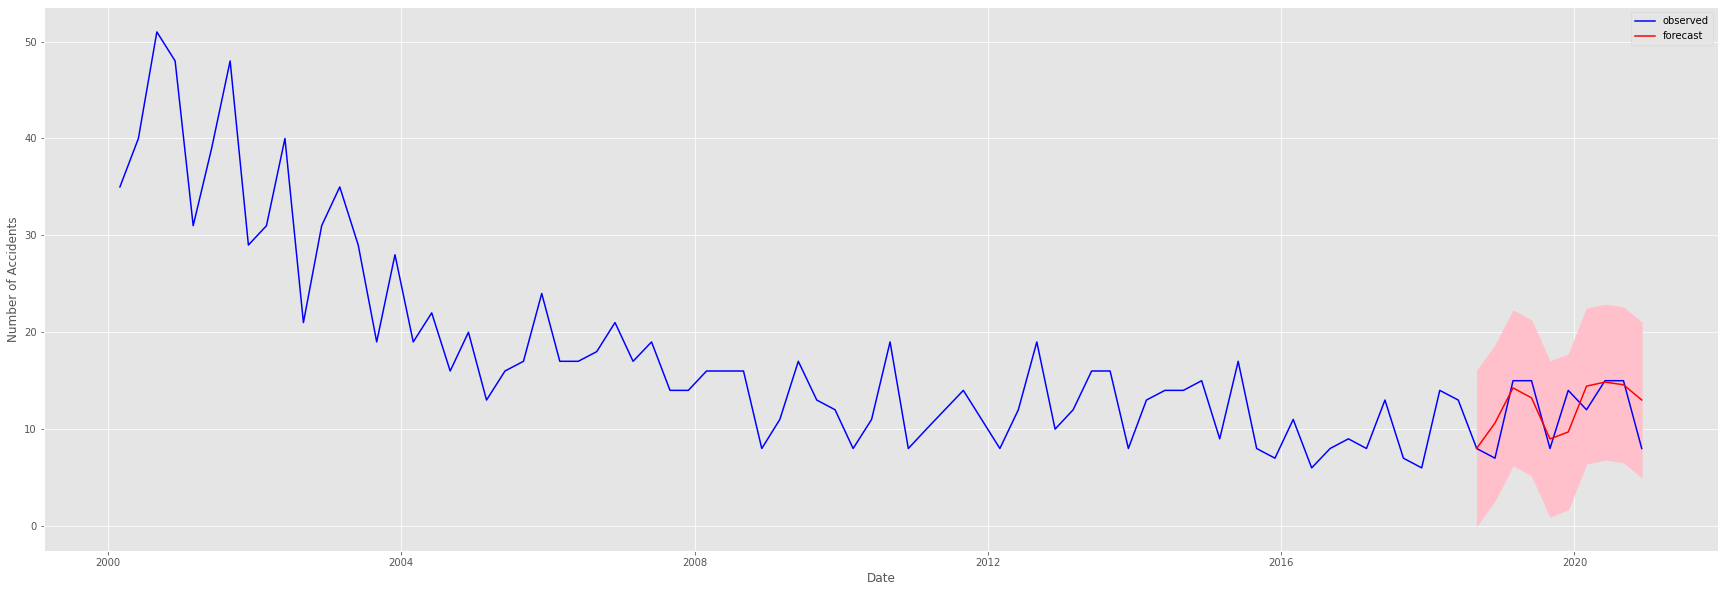

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

The blue line is the total number of actual accidents. The red line is a prediction by the model on the last 10 quarters based on data from the previous quarters. The pink shaded area is the lower and upper bound of the model prediction or the confidence interval of predictions by the model. This gives an idea of the accuracy of the model.

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
6.754928316318809


In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


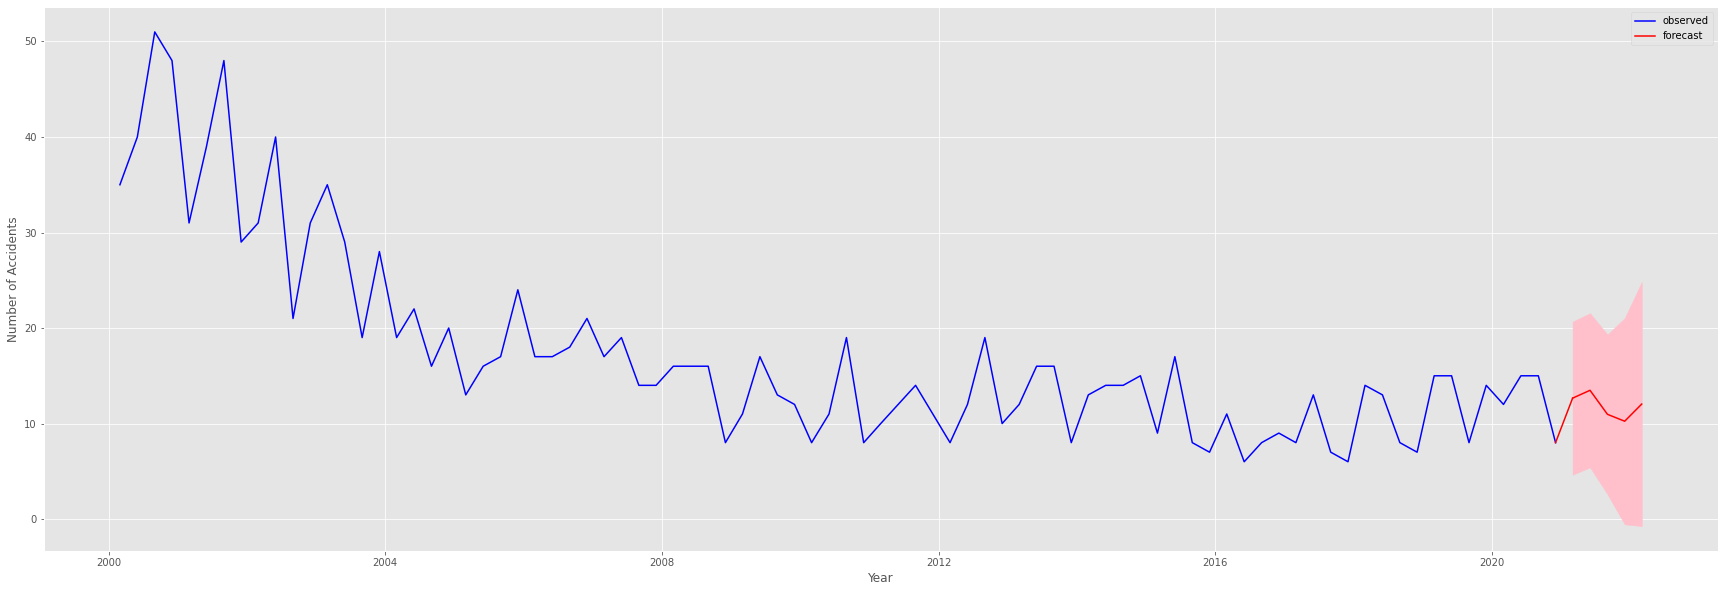

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


Predicting future values

In [ ]:
forcast= results.forecast(2)
forcast

2021-03-01    12.656632
2021-06-01    13.480008
Freq: QS-DEC, dtype: float64

### SARIMAX

### L16168

We already know the number of differencing required to make the data stationary. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


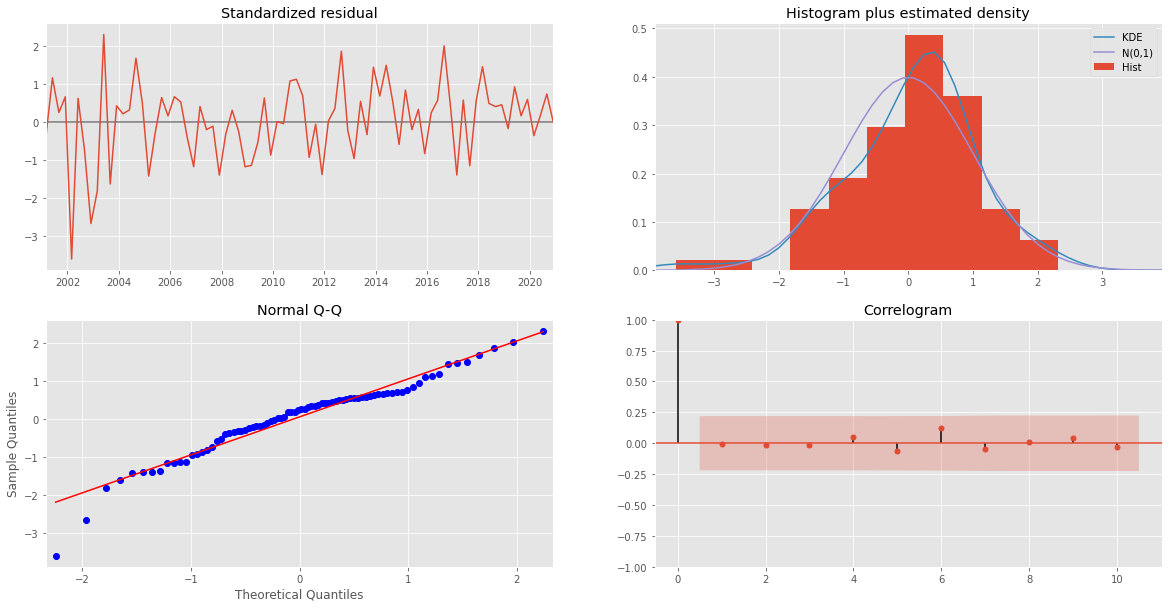

                                 Statespace Model Results                                
Dep. Variable:                         Accidents   No. Observations:                   84
Model:             SARIMAX(2, 1, 2)x(1, 1, 7, 3)   Log Likelihood                -243.329
Date:                           Mon, 09 Aug 2021   AIC                            512.658
Time:                                   14:36:32   BIC                            543.625
Sample:                               03-01-2000   HQIC                           525.074
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4184      0.263      1.593      0.111      -0.096       0.933
ar.L2         -0.5322      0.179     -2.967

In [ ]:
# yearly accidents for given operator
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L16168'] # change mine id here
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Q').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

model = SARIMAX(new, order=(2,1,2),seasonal_order=(1,1,7,3))
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

Model diagnostics look good

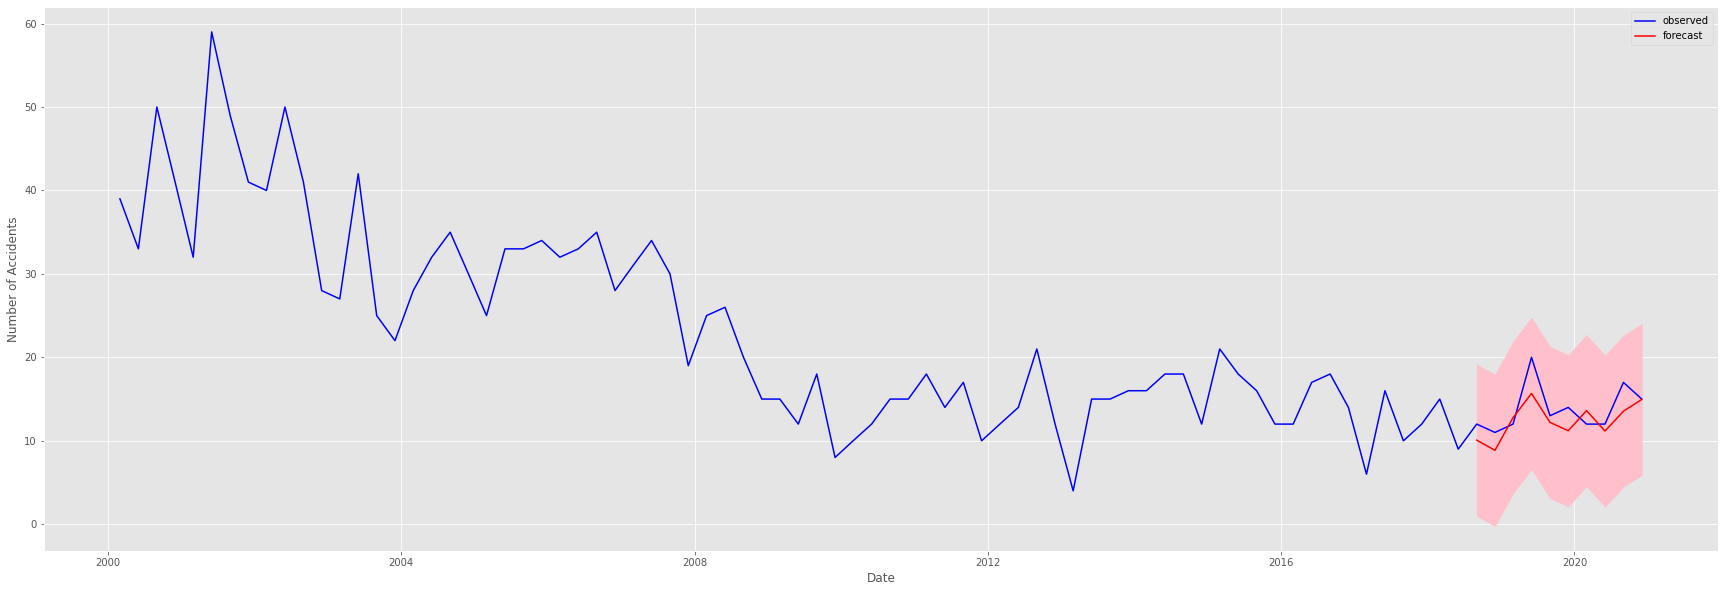

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

# getting the values for the confidence interval, this will be shaded in the plot to get an idea of the model confidence
lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

Model looks very accurate

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
5.123197250718259


MSE is lower compared to ARIMA model. (lower the MSE, better the model)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


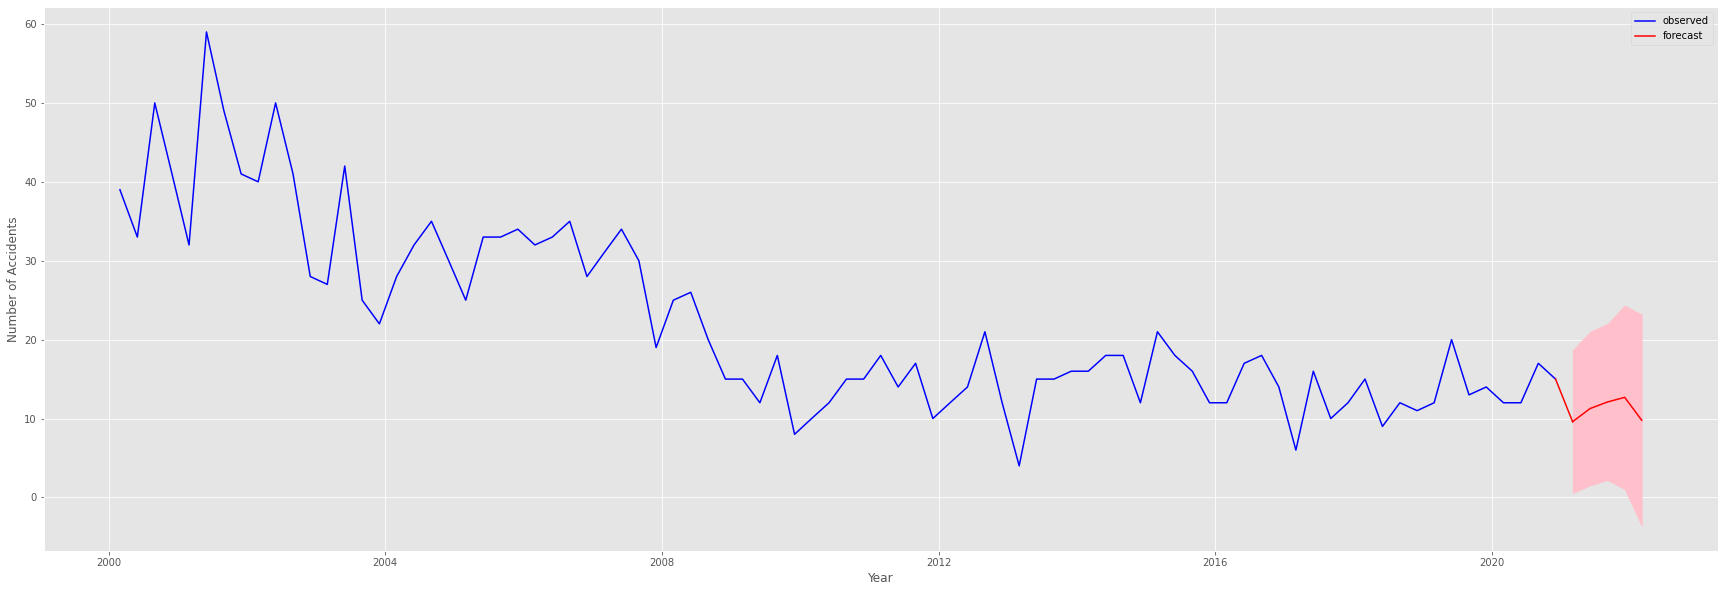

In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


Model predicts that the number of accidents is likely to go down over the quarters

In [ ]:
forcast= results.forecast(5)
forcast

2021-03-01     9.599122
2021-06-01    11.264566
2021-09-01    12.098331
2021-12-01    12.687411
2022-03-01     9.782789
Freq: QS-DEC, dtype: float64

### L12058

This data was already stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

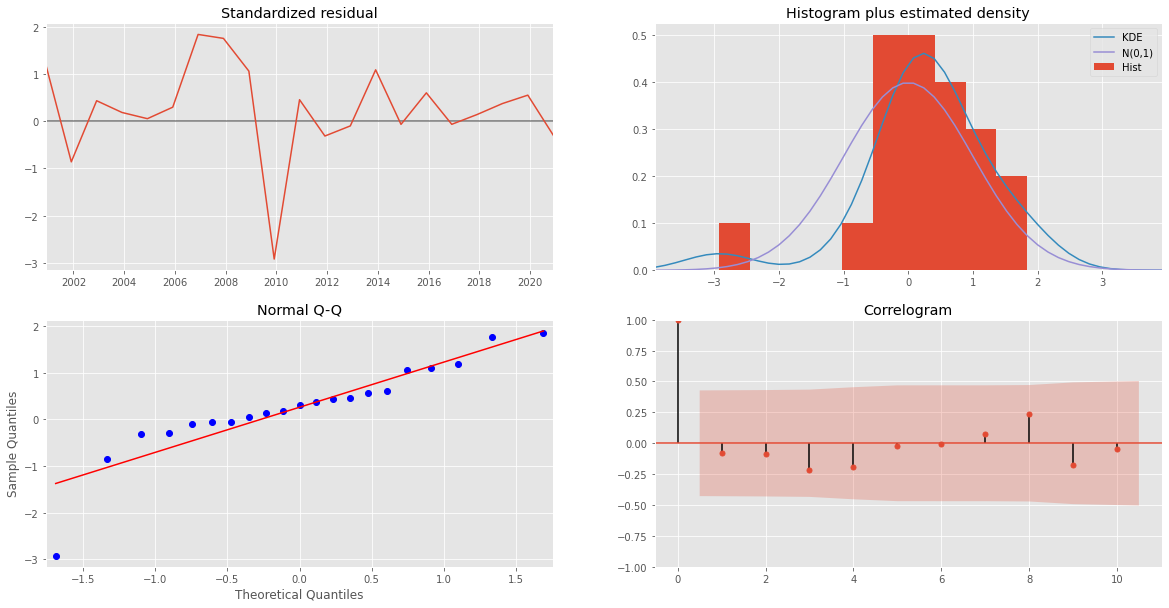

                                 Statespace Model Results                                
Dep. Variable:                         Accidents   No. Observations:                   21
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 6)   Log Likelihood                -110.448
Date:                           Mon, 09 Aug 2021   AIC                            232.897
Time:                                   14:36:34   BIC                            239.164
Sample:                               12-01-2000   HQIC                           234.257
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0618      1.374      0.045      0.964      -2.631       2.755
ar.L2          0.5547      1.222      0.454

In [ ]:
# yearly accidents for given operator
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L12058']
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Y').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

model = SARIMAX(new, order=(2,0,1),seasonal_order=(1,0,1,6))
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

Model diagnostics are as expected for a good model

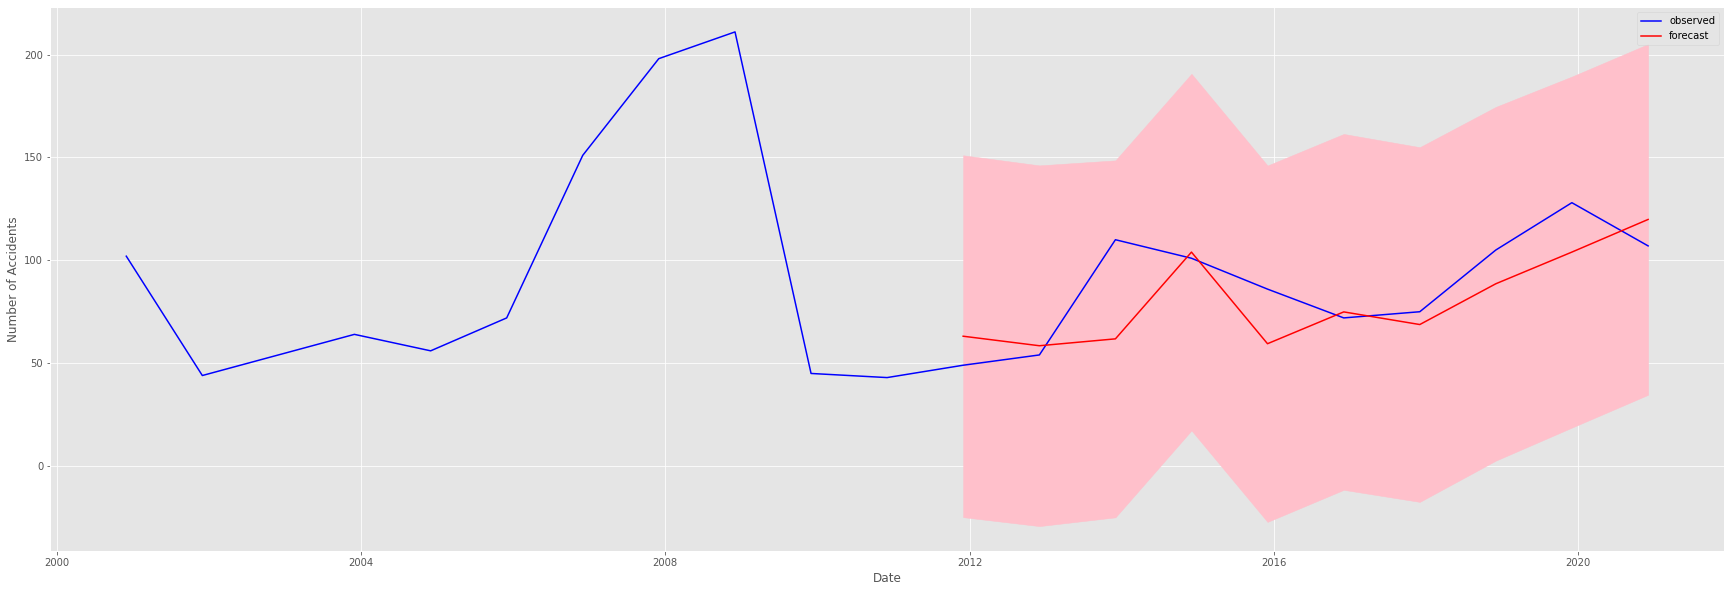

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

# getting the values for the confidence interval, this will be shaded in the plot to get an idea of the model confidence
lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

Since this plot does not show any seasonal behavior, also the MSE is high compared to theat of the ARIMA model.. So in this case the ARIMA model is a better fit

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
431.16219930512295


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


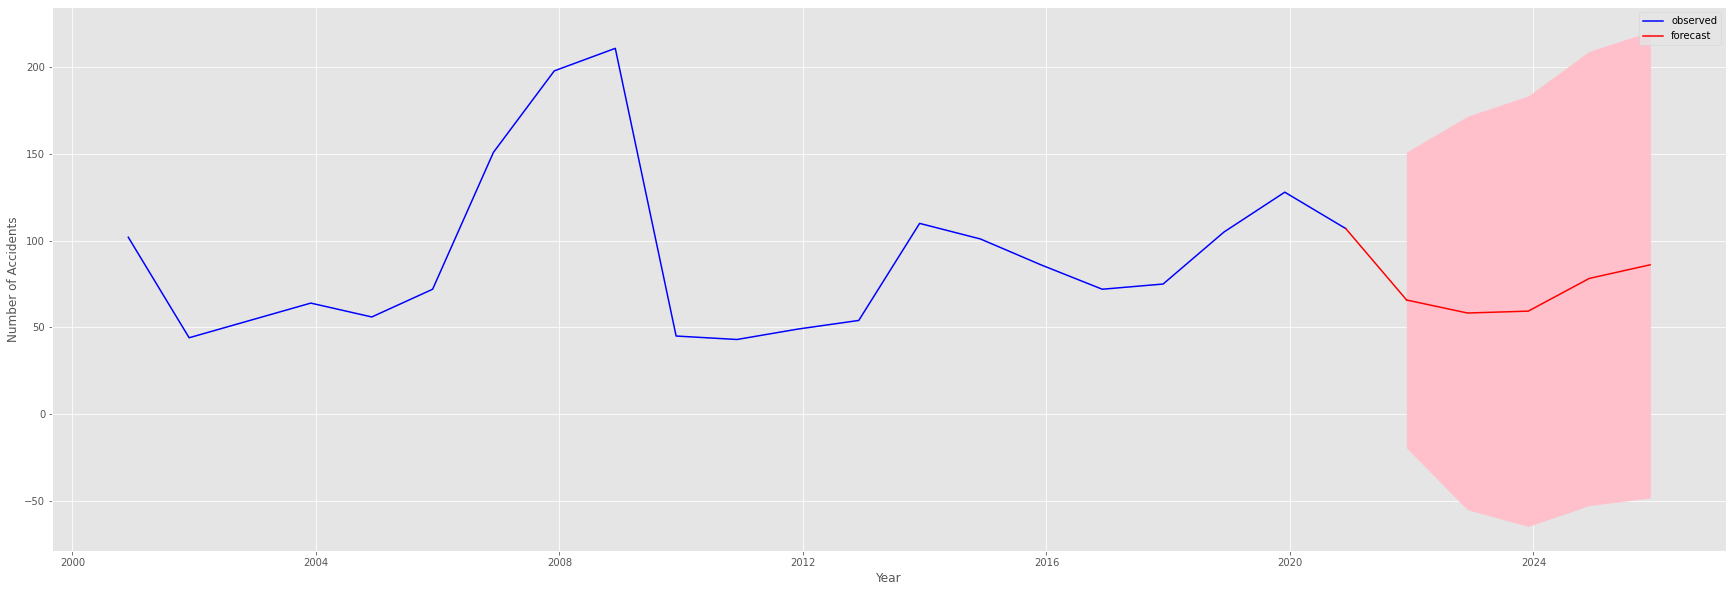

In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


In [ ]:
forcast= results.forecast(5)
forcast

2021-12-01    65.777031
2022-12-01    58.281980
2023-12-01    59.363465
2024-12-01    78.246229
2025-12-01    86.089434
Freq: AS-DEC, dtype: float64

### L14843

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


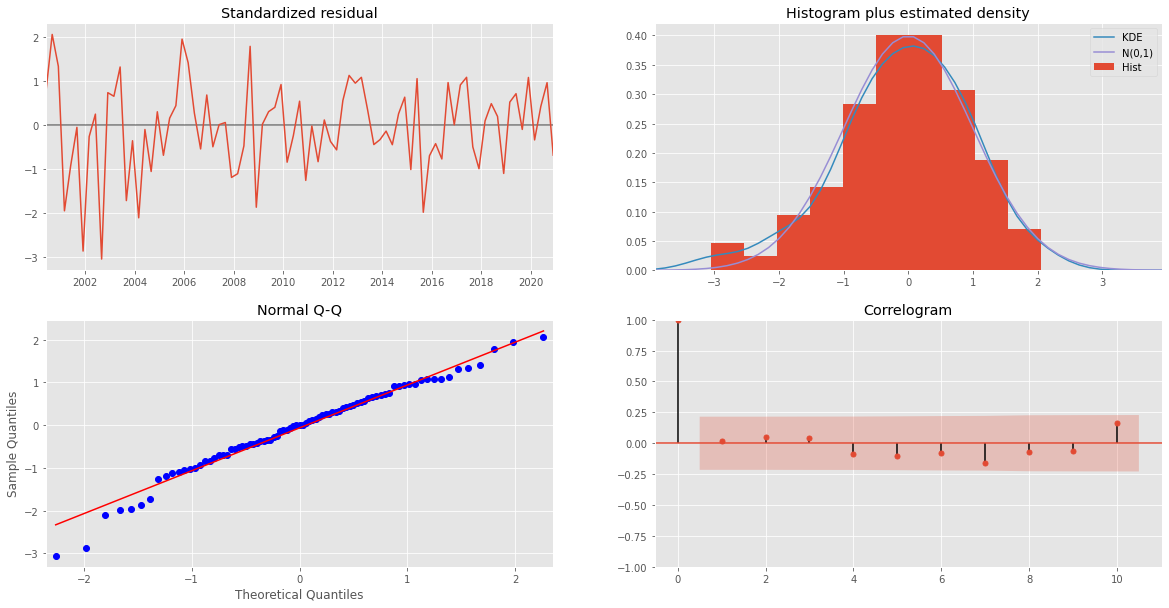

                                 Statespace Model Results                                
Dep. Variable:                         Accidents   No. Observations:                   84
Model:             SARIMAX(2, 1, 2)x(4, 0, 6, 4)   Log Likelihood                -234.657
Date:                           Mon, 09 Aug 2021   AIC                            499.314
Time:                                   14:36:40   BIC                            535.597
Sample:                               03-01-2000   HQIC                           513.891
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8937      0.227     -3.935      0.000      -1.339      -0.449
ar.L2         -0.6479      0.099     -6.527

In [ ]:
# yearly accidents for given operator
first_op = accident_ext[accident_ext['Operator ID @ Accidents'] == 'L14843'] # change mine id here
first_op = first_op.groupby('Accident Date (Accidents)').agg({'Mine ID':'count'})
first_op.rename(columns={'Mine ID':'Accidents'}, inplace=True)
new = first_op.resample('Q').sum()
new.index = new.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

model = SARIMAX(new, order=(2,1,2),seasonal_order=(4,0,6,4))
results = model.fit()

results.plot_diagnostics(figsize=(20,10))
plt.show()

print(results.summary())

The model diagnostics plots tell us that the model is a fairly good one as the model 

● Does not have any obvious structures in the residuals in the Standardized residual plot.

● The KDE and N(0,1) lines in the Histogram plus estimated density are almost the same. 

● Have dots lying along the red line in the Q-Q plot.

● 95% of the correlations for lag greater than 0 should is not significant in the Correlogram

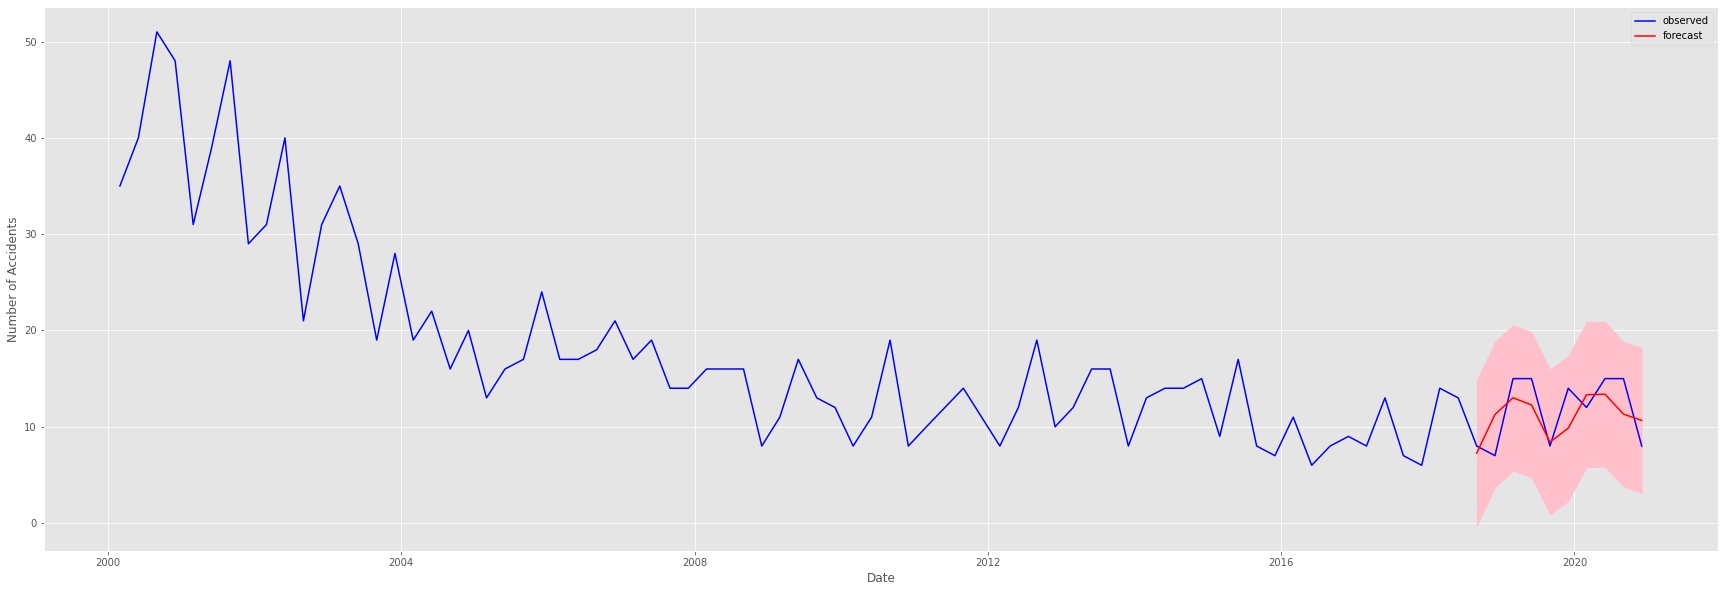

In [ ]:
one_step_forecast = results.get_prediction(start=-10)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals

# getting the values for the confidence interval, this will be shaded in the plot to get an idea of the model confidence
lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']

plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

Model looks fairly accurate

In [ ]:
print('Mean Sqaured Error:')
actual = new[-len(mean_forecast):].values.ravel()
pred = mean_forecast.values.ravel()

print(mean_squared_error(actual, pred))

Mean Sqaured Error:
7.257968626435698


MSE looks good too.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


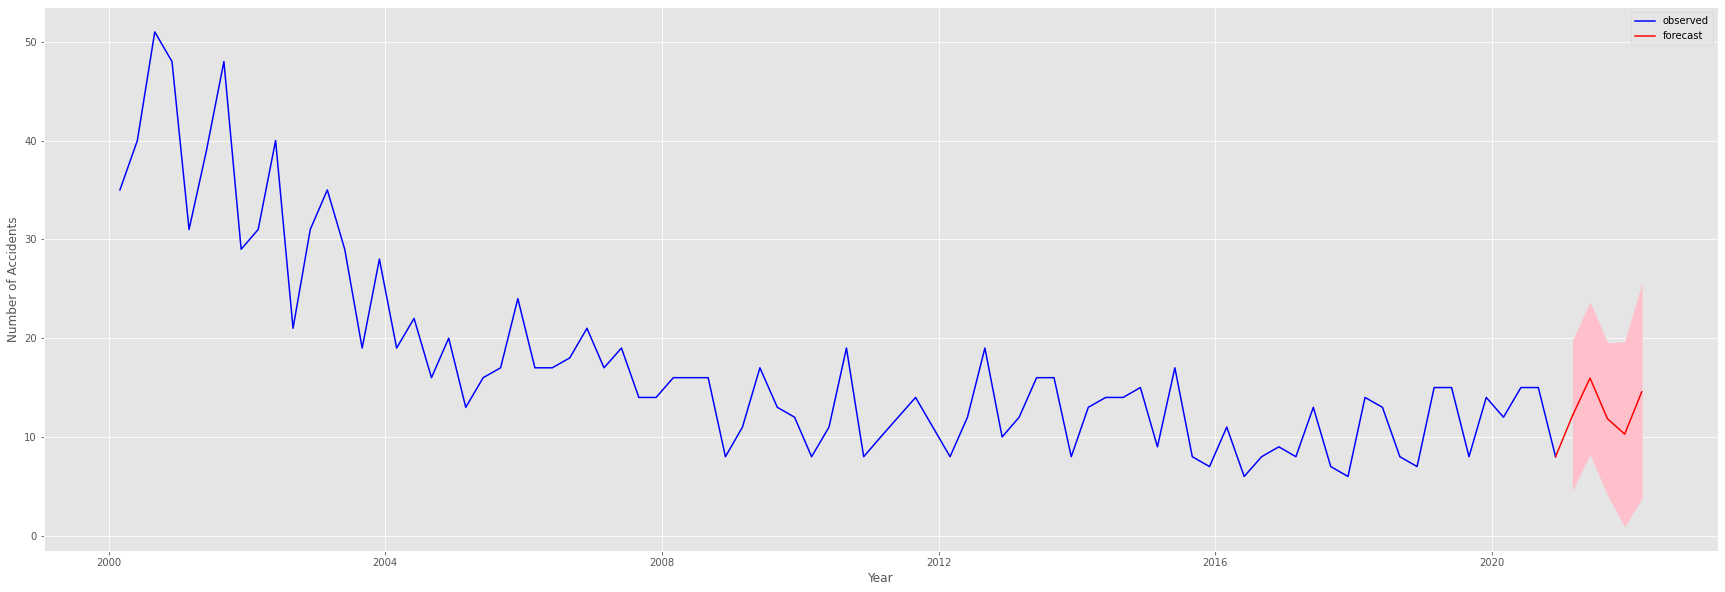

In [ ]:
dynamic_forecast = results.get_forecast(steps=5)

mean_forecast = dynamic_forecast.predicted_mean

confidence_intervals= dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Accidents']
upper_limits = confidence_intervals.loc[:,'upper Accidents']


plt.figure(figsize=(30,10))
plt.plot(new.index, new, label='observed', color='b')

plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')

plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')

join_x = [new.index[-1],mean_forecast.index[0]]
join_y = [new.values[-1], mean_forecast.values[0]]

plt.plot(join_x, join_y, color='r')

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


Model predicts the number of accident to spike in the few quarters.

In [ ]:
forcast= results.forecast(5)
forcast

2021-03-01    12.183565
2021-06-01    15.959403
2021-09-01    11.847166
2021-12-01    10.283575
2022-03-01    14.564266
Freq: QS-DEC, dtype: float64